In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import newton, brentq
from scipy.ndimage.filters import gaussian_filter1d
import pandas as pd

In [3]:
# Variáveis para o gráfico
plot_params = {'legend.fontsize': 30,
               'figure.figsize': (20, 10),
               'axes.labelsize':  30,
               'axes.titlesize':  30,
               'xtick.labelsize': 25,
               'ytick.labelsize': 25}

plt.style.use('ggplot')

plt.rcParams.update(plot_params)

color_dark_blue = [1/255, 62/255, 125/255]
color_light_blue = [6/255, 143/255, 203/255]
purple = [102/255, 51/255, 153/255]

color = [color_dark_blue, color_light_blue, purple]

In [10]:
S0 = 100
K = 110
H = 130
r = 0.0
T = 1.0
M = int(1e2)
time = np.linspace(0, T, M+1)
dt = time[1] - time[0]
N_op = int(1e5)  # number of simulations to compute the option prices
dW = np.sqrt(dt) * np.random.normal(size=(len(time)-1, N_op))

S0_normalizing = K
T_final = T
sigma0 = 0.2

In [5]:
def LocalVolExample(t, S):

    y = np.log(S/S0_normalizing)
    tau = T_final - t

    #lv = sigma0 - sigma0 * y0 * np.exp(-tau) * np.cos(1.25 * np.pi * y) * (np.abs(y) < y0)

    lv = sigma0 * (S < 1.1*K) + sigma0/2 * (S > 1.1*K) 

    return lv

In [6]:
def LocalVolSimulation(S0, mu, sigma, time, N=int(1e5), dW=None, randomS0=False):

    len_time = len(time)

    if dW is None:
        dW = np.sqrt(dt) * np.random.normal(size = (len_time-1, N))

    S = np.zeros((len_time, N))

    if randomS0:
        S[0, :] = np.random.normal(S0, scale=np.sqrt(S0), size=N)
    else:
        S[0, :] = S0

    for t in range(len_time-1):
        #S[t+1, :] = S[t, :] * (1 + mu * dt + sigma(time[t], S[t, :]) * dW[t, :])
        vol = sigma(time[t], S[t, :])
        S[t+1, :] = S[t, :] * np.exp((mu - 0.5 * vol**2) * dt + vol * dW[t, :])

    return S

In [7]:
def LocalVolBarrierPrice(t, S0, T, K, H, r, sigma, N, dW, time=None):

    if time is None:
        time = np.linspace(t, T, int((T-t)*M/T))

    simulated_path = LocalVolSimulation(S0, r, sigma, time, N, dW)

    max_S = np.max(simulated_path, axis=0)

    payoff = np.maximum(simulated_path[-1, :] - K, 0.0) * (max_S < H)

    C = np.exp(-r*(time[-1]-t)) * np.mean(payoff)

    error = np.exp(-r*(time[-1]-t)) * np.std(payoff)/np.sqrt(N)

    return C, error

In [8]:
def BSBarrierPrice(t, S0, T, K, H, r, sigma, N, dW, time=None):

    if time is None:
        time = np.linspace(t, T, int((T-t)*M/T))

    dX = (r - 0.5 * sigma ** 2) * dt + sigma * dW

    simulated_path = S0 * np.exp(np.cumsum(dX, axis=0))

    max_S = np.max(simulated_path, axis=0)

    payoff = np.maximum(simulated_path[-1, :] - K, 0.0) * (max_S < H)

    C = np.exp(-r*(time[-1]-t)) * np.mean(payoff)

    error = np.exp(-r*(time[-1]-t)) * np.std(payoff)/np.sqrt(N)

    return C, error

In [11]:
barrier_price, error = LocalVolBarrierPrice(0.0, S0, T, K, H, r, LocalVolExample,  N_op, dW)

In [12]:
N_v = 50
sigma = np.linspace(0.01, 0.5, N_v+1)

barrier_BS = np.zeros_like(sigma)

for i in range(N_v+1):
    barrier_BS[i] = BSBarrierPrice(0.0, S0, T, K, H, r, sigma[i], N_op, dW)[0]

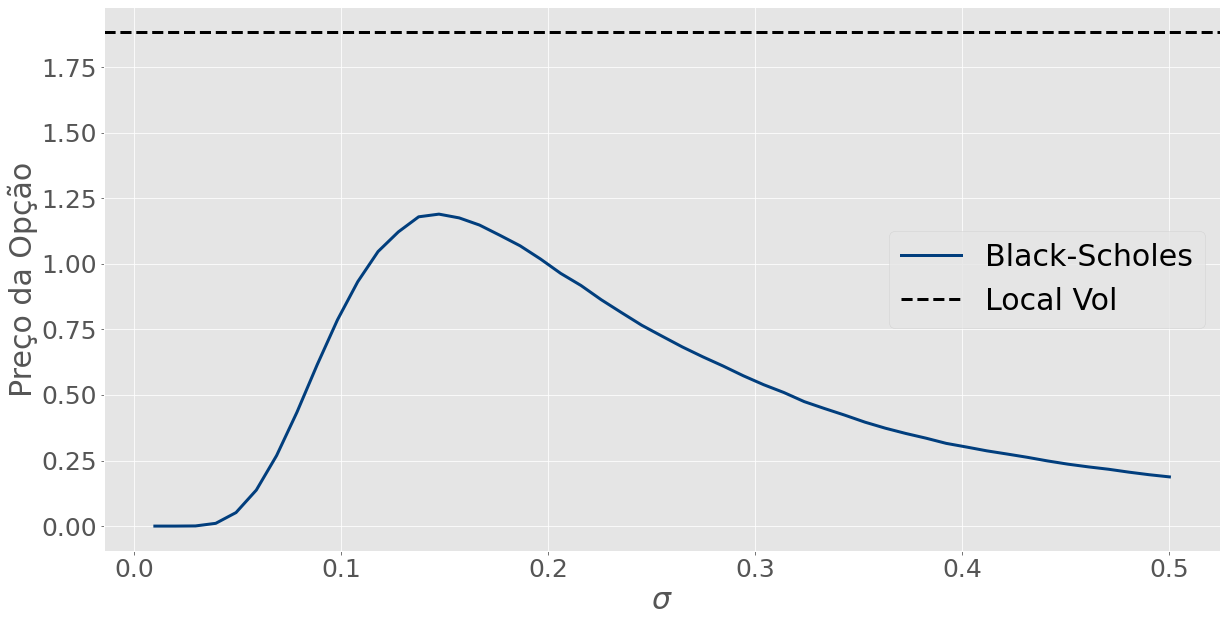

In [14]:
plt.figure()
plt.plot(sigma, barrier_BS, label='Black-Scholes', linewidth=3, color=color_dark_blue)
plt.axhline(barrier_price, color='k', linestyle='dashed', linewidth=3, label='Local Vol')
plt.xlabel(r'$\sigma$')
plt.ylabel('Preço da Opção')
plt.legend()